# Data Story on Song Lyrics

### Lyrics is one of the most importance sources to convey the artists's sentiments and emotion. In the project, we are going to use natural language precessing and text mining to investigate patterns and characteristics of difference type of songs lyrics and to derive interesting findings in the collection of song lyrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import string
import re

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
sns.set(color_codes=True)
import numpy as np

from wordcloud import WordCloud
from PIL import Image, ImageDraw, ImageFont

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

## Loading Data
### For this porject, we will use the a filtered corpus of 100,000+ song lyrics from MetroLyrics.
### Let's start by looking at some basic information of the dataset.

In [2]:
# load lyrics
lyrics = pd.read_csv('lyrics.csv')

In [3]:
#the dimension of the data
lyrics.shape

(125715, 5)

In [4]:
#check missing values
lyrics.isna().sum()

song      0
year      0
artist    0
genre     0
lyrics    0
dtype: int64

In [5]:
# check data types
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125715 entries, 0 to 125714
Data columns (total 5 columns):
song      125715 non-null object
year      125715 non-null int64
artist    125715 non-null object
genre     125715 non-null object
lyrics    125715 non-null object
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


## Text preprocess and Data Cleaning
###  We will perform text preprocess to make lyrics more amenable for analysis by using a regular expression to remove punctuations and convert text to lower case, remove empty words and get stemmed.

In [6]:
# Stop words.
stop_words = set(['lot','today','months','month','wanna','wouldnt','wasnt',
                  'ha','na','ooh','da','gonna','im','dont','aint','wont','yeah',
                  'la','oi','nigga','fuck','hey','year','years','last','past','feel']+nltk.corpus.stopwords.words('english'))

In [7]:
# Word stemmer
ps = PorterStemmer()

In [8]:
def clean(text):
    # Use regular expression to remove punctuations, and convert text to lowercase
    text =  re.sub("[%s]"%string.punctuation,"",text).lower()
    # Split the text into words
    words = text.split()
    # Remove empty word and get stem
    return[ps.stem(word) for word in words if word not in stop_words and len(word)>0]

# Clean the text
lyrics['lyrics_clean'] = lyrics.lyrics.apply(clean)

## Part 1: Exploratory Data Analysis
### In this part, we will apply EDA techniques to discover the general pattern of song lyrics and artist information.
#### First of all, we analyze the lyrics length distribution in each year.

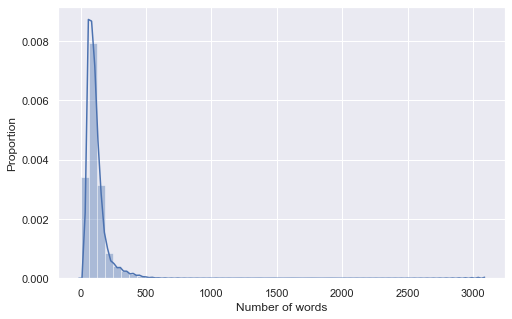

In [9]:
# The word length distribution
plt. figure(figsize = (8,5))
word_length = lyrics.lyrics_clean.apply(lambda x: len(x))
sns.distplot(word_length.values, kde = True)
plt.xlabel("Number of words")
plt.ylabel("Proportion")
plt.show()

#### The songs consist of 250 words on average. However, there are also some longer songs with 500 words. This accord with the 80/20 rules in statistics.

In [10]:
# Select n artist with most songs
n = 10
# Sort the artist by the number songs
artist_counts = lyrics.artist.value_counts().sort_values().iloc[-n:]

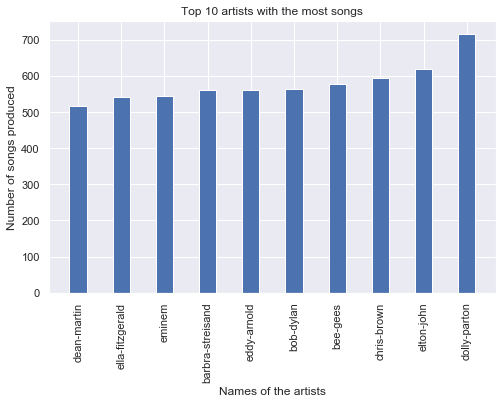

In [11]:
plt.figure(figsize=(8,5))
plt.title("Top 10 artists with the most songs")
plt.bar(artist_counts.index,artist_counts.values,width = 0.4)
plt.xticks(rotation = 90)
plt.xlabel("Names of the artists")
plt.ylabel("Number of songs produced")
plt.show()

#### We then further look at the proportion of genres in each year.

In [12]:
# Calculate the proportion  of genres in each year
# Group the lyrics by year, and count the genres in each year, then calculate proportion
genre_propotion = lyrics.groupby("year")["genre"].value_counts()/lyrics.groupby('year').size()
# Set column name
genre_propotion = genre_propotion.reset_index().rename({0:"propotion"},axis = 1)
# Select year after 2000
genre_propotion = genre_propotion[genre_propotion.year >= 2000]

In [13]:
genres =  lyrics.genre.value_counts().index
genres

Index(['Rock', 'Pop', 'Metal', 'Hip-Hop', 'Country', 'Jazz', 'Not Available',
       'Electronic', 'R&B', 'Indie', 'Folk', 'Other'],
      dtype='object')

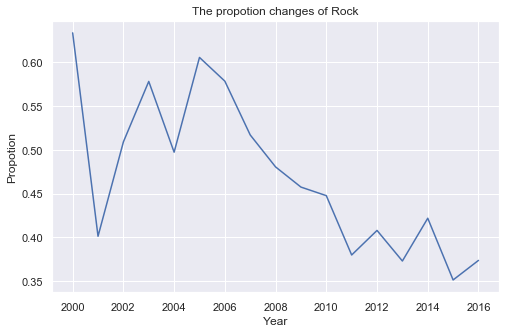

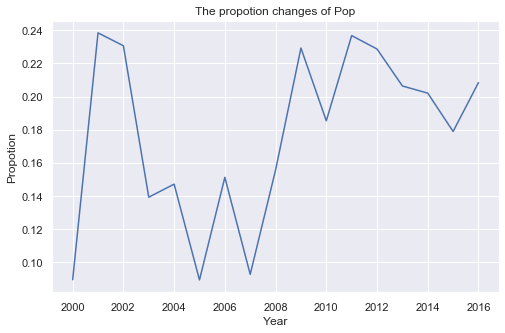

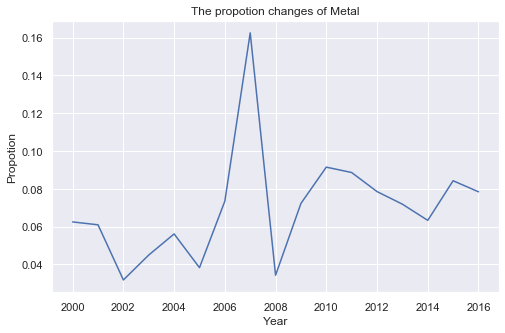

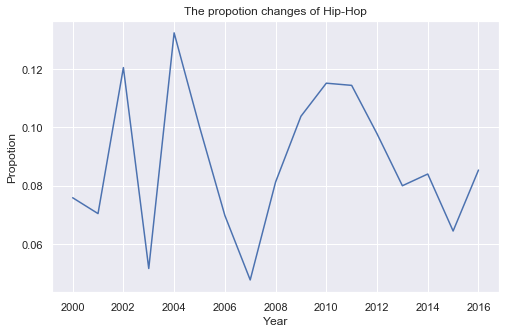

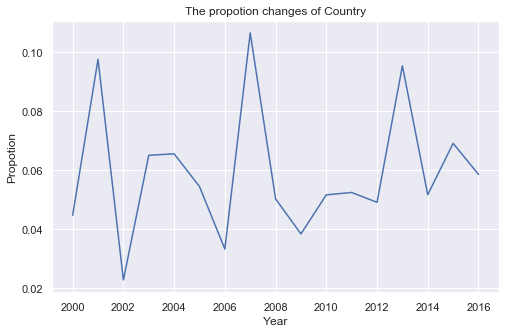

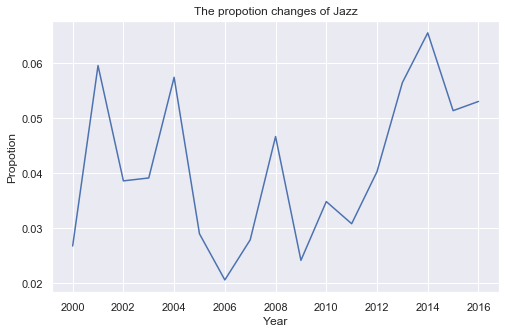

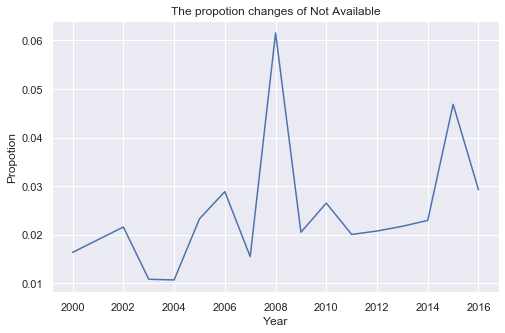

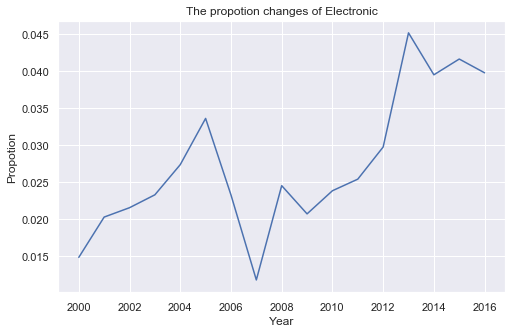

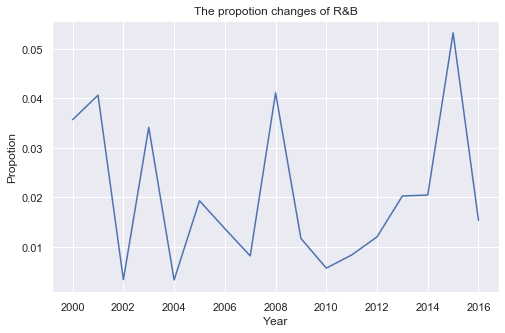

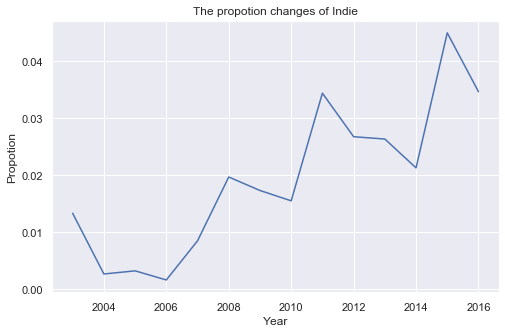

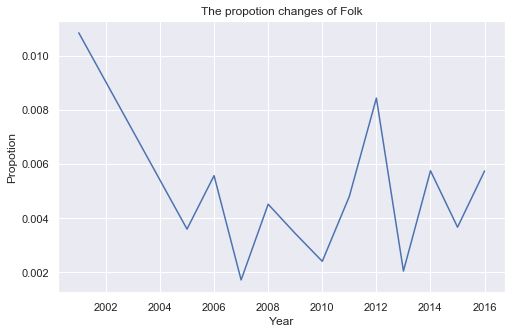

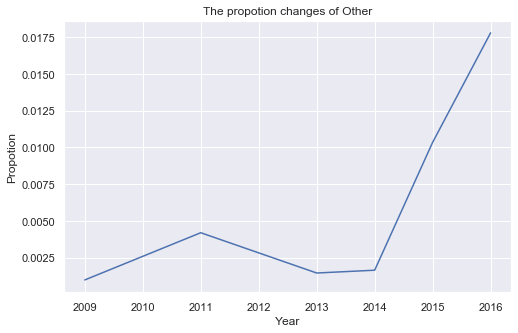

In [14]:
for genre in genres:
    # Select the data in the genre
    df = genre_propotion[genre_propotion.genre == genre]
    plt.figure(figsize = (8,5))
    plt.title("The propotion changes of %s"%genre)
    sns.lineplot(x=df.year,y= df.propotion, markers = True,dashes = False,)
    plt.xlabel("Year")
    plt.ylabel("Propotion")
    plt.show()

#### From the charts above, we observed that the evolution of each genre after 2000. Rock/Folk Music has a declining trend after the year 2000.  This reason might be that the Rock/Folk struggled after the 2000s when dance and electro music largely took over pop radio.  The number of Electronic Music increases after the year 2000. This is because, as computer technology has become more accessible and music software has advanced, interacting with music production technology is now possible to produce electronic music.

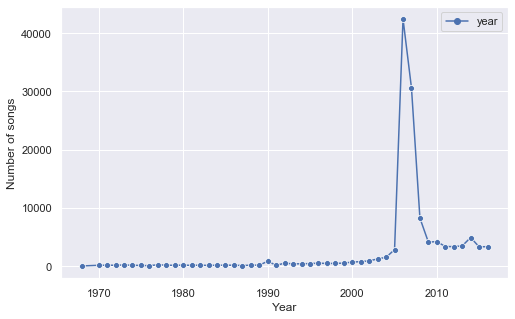

In [15]:
# Count the number of songs in each year
song_counts = pd.DataFrame(lyrics.year.value_counts().sort_index(ascending=False).iloc[:-2])
# Set figure size
plt.figure(figsize=(8,5))
# Line plot
sns.lineplot(data = song_counts,markers = True, dashes = False,)
plt.xlabel("Year")
plt.ylabel("Number of songs")
plt.show()

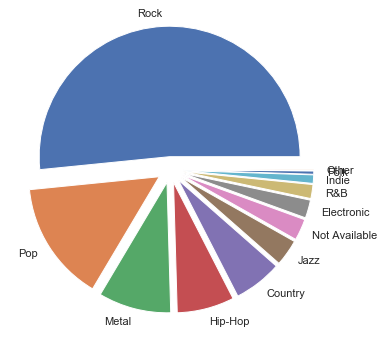

In [16]:
# The count of lyrics genres
counts = lyrics.genre.value_counts()
plt.figure(figsize = (6,6)) 
pie = plt.pie(counts,labels = counts.index,explode = [0.1 for i in range(len(counts))])
plt.show()

### The dot chart shows that there are the most songs produced in 2006 and 2007 and the bar chart note that the rock/pop/metal genre music become the majority in the data.
### Therefore we further focus on lyrics on year 2006 and 2007 and pop/metal/rock music.

## Part 2: Analytics
### 2.1 WordCloud 
### We will be making wordclouds for the visual representation of the most common words on lyrics.
#### WordCloud of 2006 and 2007


In [17]:
def get_img(text):
    """Given a string, create a image that contain that string"""
    # The font
    font = ImageFont.truetype("SHOWG.TTF", 250)
    # Create an empty image
    im = Image.new("RGB", (1200, 300), "white")
    draw = ImageDraw.Draw(im)
    # Draw text
    draw.text((0, 0), text, fill="black", spacing=100, font=font)
    return np.array(im)

In [18]:
def get_frequency(lyrics):
    """Given as list of lyrics word list, return the word frequency."""
    words = []
    for v in lyrics:
        words.extend(v)
    return Counter(words)

In [19]:
def draw_wordcloud(key, corpus):
    """Given key and corpus, generate a wordcloud"""
    word_frequency = get_frequency(corpus)
    im = get_img(key)
    # Draw word cloud
    wc = WordCloud(background_color="white", mask=im).generate_from_frequencies(word_frequency)
    plt.figure(figsize=(30, 10))
    plt.title(key, fontdict={'size': 20})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [20]:
lyrics.head(3)

,song,year,artist,genre,lyrics,lyrics_clean
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...,"[stop, hous, call, home, littl, rundown, grass..."
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,"[unsur, take, hand, lead, danc, floor, music, ..."
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,"[mark, sunday, footbal, got, boot, pitch, peop..."


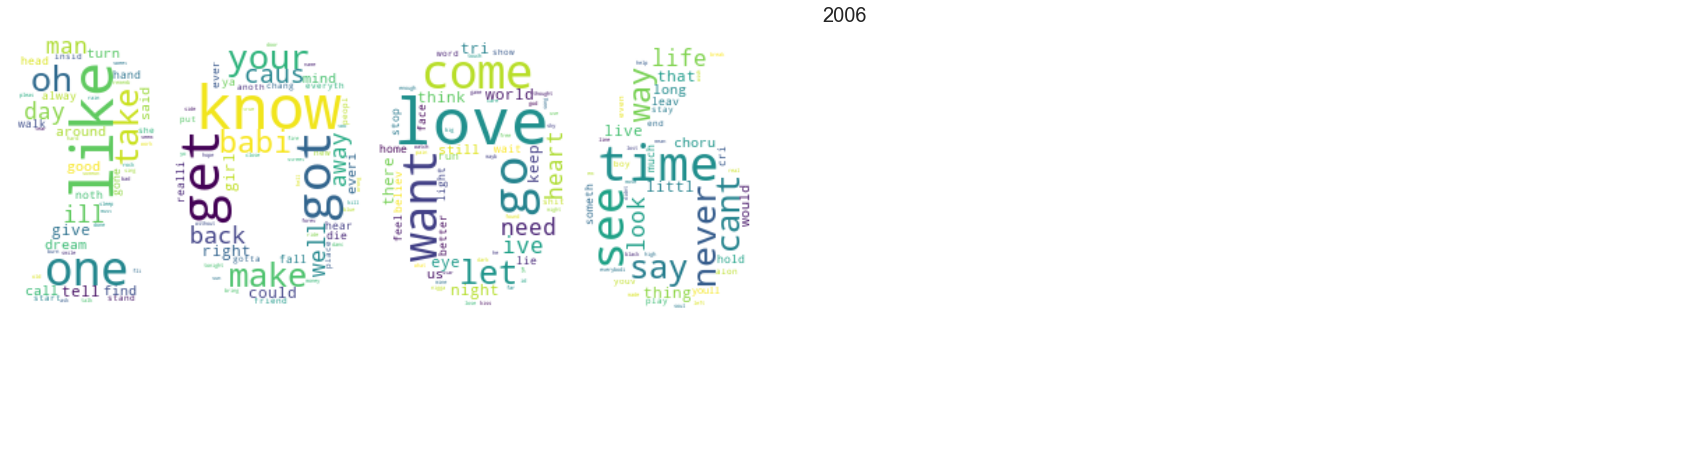

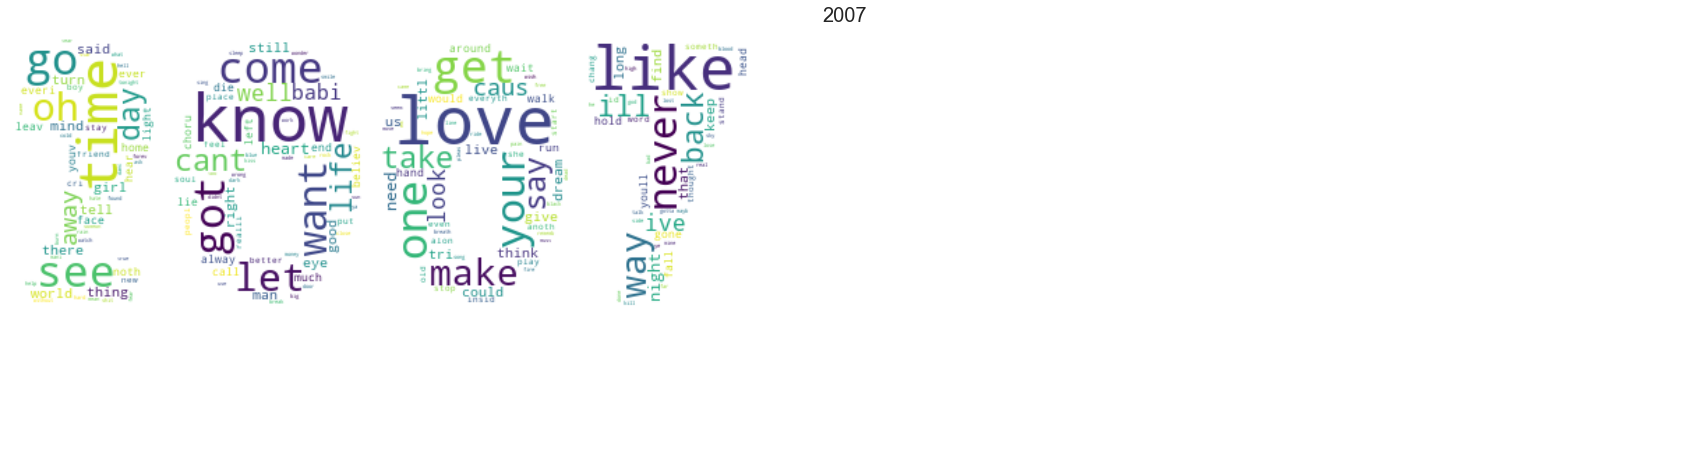

In [21]:
for year in [2006, 2007]:
    corpus = lyrics[lyrics.year == year].lyrics_clean
    draw_wordcloud(str(year), corpus)

#### In general, words like "like","love","know" occur frequently in 2006 and 2007.

#### WordCloud of Rock/Pop/Music

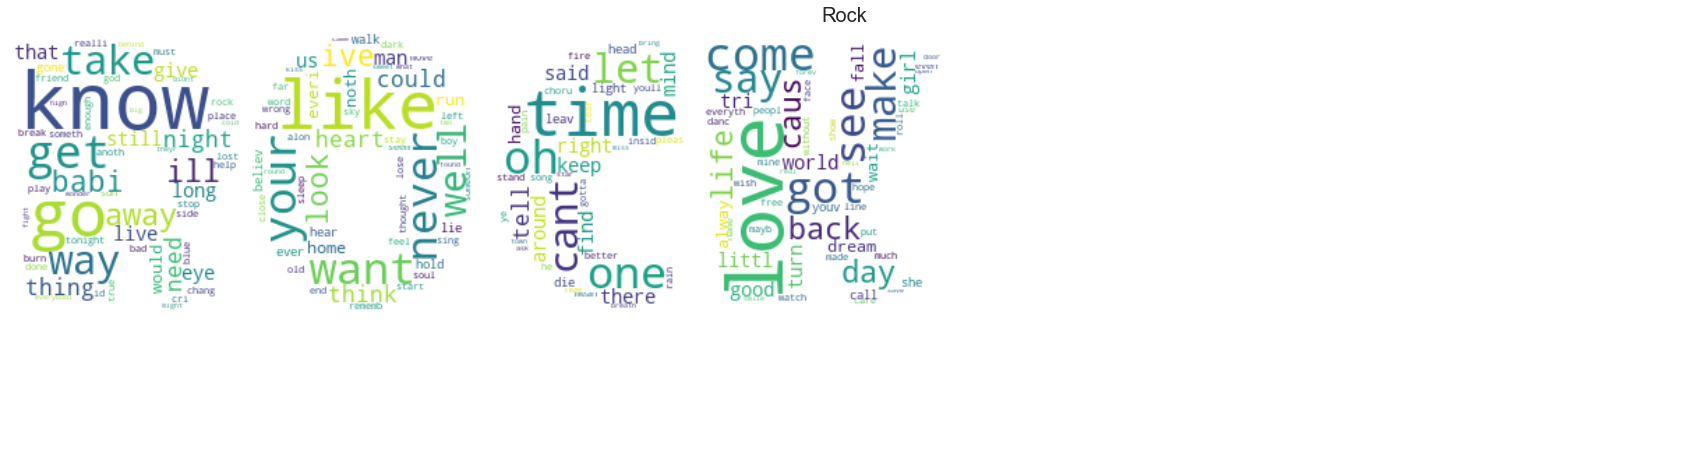

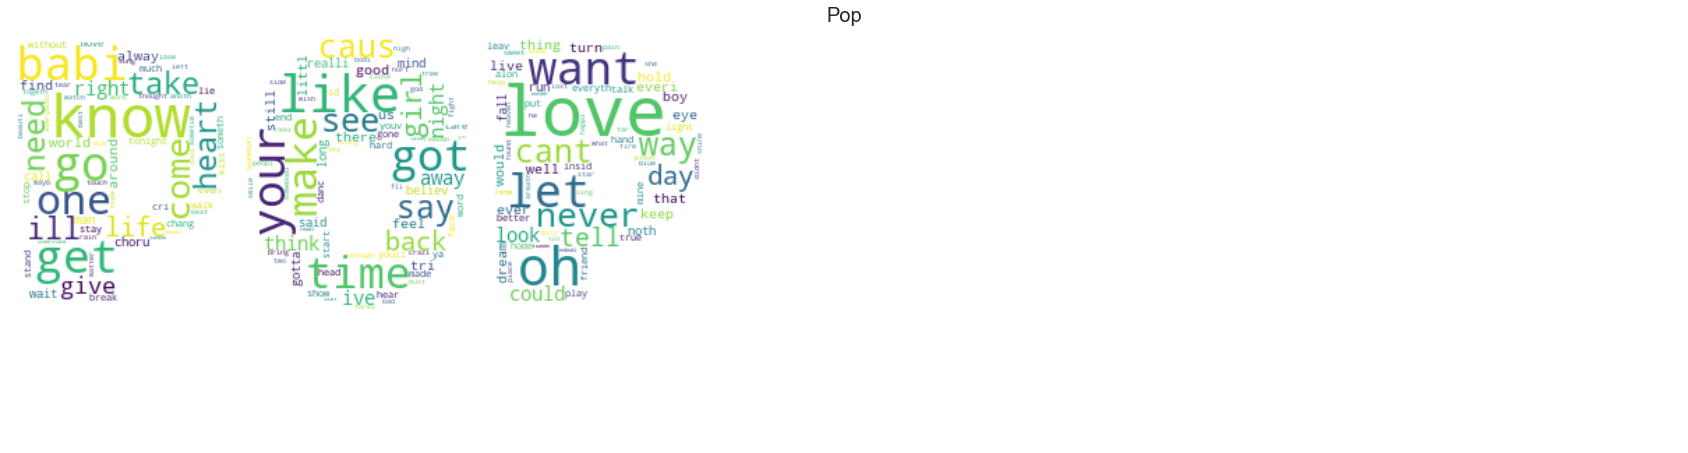

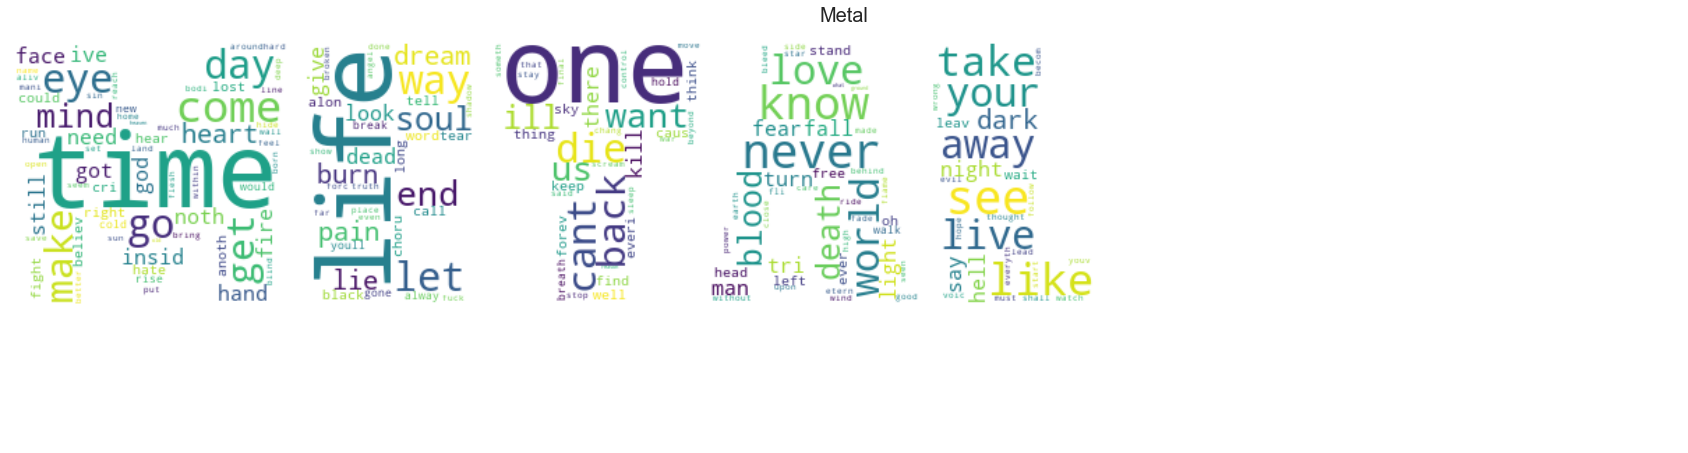

In [22]:
for genre in ['Rock', 'Pop', 'Metal']:
    corpus = lyrics[lyrics.genre == genre].lyrics_clean
    draw_wordcloud(genre, corpus)

#### The metal music use more words with higher frequency: “away”, “one”, “cant”, and so on. It seems that the Metal music have more “nagative" words than the rock/pop music which consist of the more passionate words like "like","love","know"...

## 2.2 Sentiment Analysis
### In the sentiment anslysis, we will use polarity score to understand the opinion expressed by it. We quantify this sentiment with a positive or negative value and will tell us if the lyrics contain positive or negative feedback.


#### the sentiment analysis of year 2006 and 2007


In [23]:
# Get cleaned lyrics, which is joined by clean words
lyrics["lyrics_clean_join"] = lyrics.lyrics_clean.apply(lambda x: ' '.join(x))

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ShuyiChen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
sid = SentimentIntensityAnalyzer()

In [27]:
# Select songs in year 2006 and 2007
song = lyrics[(lyrics.year == 2006)|(lyrics.year == 2007)].copy()
# Sentiment analysis
song['polarity_score'] = song.lyrics.apply(lambda x: sid.polarity_scores(x)['compound'])

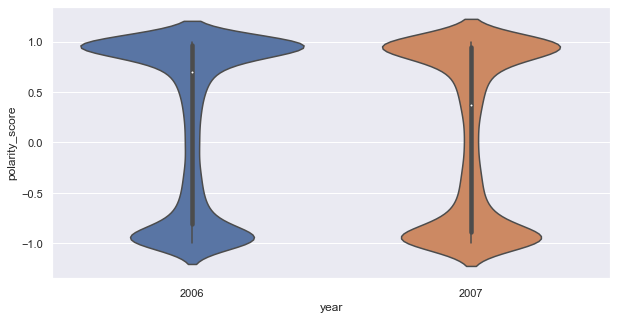

In [28]:
# The sentiment distribution in different year
plt.figure(figsize=(10, 5))
sns.violinplot(x='year', y='polarity_score', data=song[song.genre.apply(lambda x: x in ['Rock', 'Pop', "Metal"])])
plt.show()

#### We can notice that in 2006 and 2007, the lyrics tend to be filled with more of positive attitude.

#### the sentiment anslysis of Rock/Pop/Metal genre.

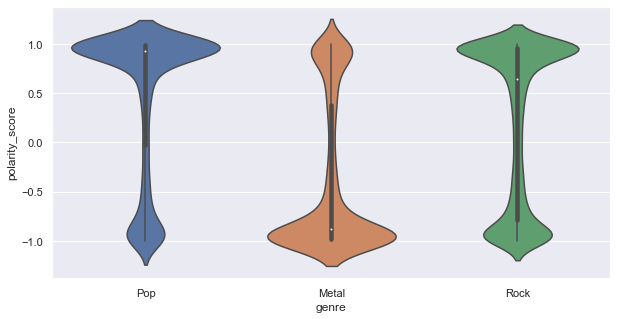

In [29]:
# The sentiment distribution in different Genres
plt.figure(figsize=(10, 5))
sns.violinplot(x='genre', y='polarity_score', data=song[song.genre.apply(lambda x: x in ['Rock', 'Pop', "Metal"])])
plt.show()

#### From the plots, we noted that there is more positive feedback on Pop/Rock song lyrics while there is more negative feed on Metal song lyrics. These are well aligned with the value of pop/metal/rock genres: Pop music usually has an engaging rhythm, approachable musical style. Metal music is driven by the aggressive and angry sounds of electric guitar and Rock music reflects energetic and powerful values.

## 2.3 Apply topic model and Latent Dirichlet Allocation(LDA)
###  Topic Model is a type of statistical modeling for discovering the abstract topics in the lyrics. LDA is an example of topic modeling to classify text in a document to particular topics. We will apply LDA approach to the year 2006 and year 2007 lyrics and split them into five topics.


#### LDA on 2006 and 2007

In [30]:
#number of features
n_features = 400
#number of toppics
n_topics = 3

In [31]:
# Select songs in year 2006 and 2007
song = lyrics[(lyrics.year == 2006)|(lyrics.year == 2007)].copy()

In [32]:
# Tokenize the words
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 100,
                               max_features = n_features,
                               stop_words = 'english')
tf = tf_vectorizer.fit_transform(song.lyrics_clean_join)

In [33]:
# Topic model
lda = LatentDirichletAllocation(n_components = n_topics,
                                max_iter = 20,
                                learning_method = "batch")
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=20,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [34]:
# Get corresponding word list
tf_feature_names = tf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" %topic_idx)
    print(" ".join([tf_feature_names[i] for i in topic.argsort()[:-10 -1:-1]]))

Topic #0:
life time away day come world eye live night dream
Topic #1:
love know oh want say babi time ill make way
Topic #2:
like got man know caus come make ya let want


#### From the wordlists generated from the topic model, song lyrics from 2006 and 2007 emphasize more optimistic words.

#### LDA on Rock/Pop/Metal music

In [35]:
# Select songs of genre ['Rock', 'Pop', 'Metal']
song = lyrics[lyrics.genre.apply(lambda x: x in ['Rock', 'Pop', 'Metal'])].copy()

In [36]:
song.shape

(94859, 7)

In [37]:
# Tokenize the words
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 100,
                               max_features = n_features,
                               stop_words = 'english')
tf = tf_vectorizer.fit_transform(song.lyrics_clean_join)
# Topic model
lda = LatentDirichletAllocation(n_components = n_topics,
                                max_iter = 20,
                                learning_method = "batch")
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=20,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [38]:
# Get corresponding word list
tf_feature_names = tf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" %topic_idx)
    print(" ".join([tf_feature_names[i] for i in topic.argsort()[:-10 -1:-1]]))

Topic #0:
love oh babi got like girl know come want let
Topic #1:
come life world eye day light night live away dream
Topic #2:
know time want say ill way ive like make think


#### From the metal/pop/rock music, the lyrics include both lively and pessimistice words. This is becase pop/rock and metal have different manners of expression.

## Conclusions
###  From the exploratory data analysis, we observed that there are more song lyrics on the year of 2006 and 2007 and more Rock, Pop and Metal music. Therefore, the analysis focused on these two parts.
### 1. In general, artists of the year 2006 and 2007 contain more positive and spirited emotions which are also demonstrated on the wordclouds, sentiment analysis and topics model. This exhibits the flourishing before the financial crisis in 2008.
### 2. Do the lyrics reveals the style of different genres? The words appearing frequently in Rock/Pop music: “Like”, “Love”, “go”, and so on, the words appearing frequently in the Metal music "never", "blood" show the core values of the rock music and reflect the music culture. As also noted in the sentiment analysis and polarity score, we noted that there is more positive feedback on Pop/Rock song lyrics while there is more negative feed on Metal song lyrics. These are well aligned with the value of pop/metal/rock genres.  

#### Referene:
#### 1. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
#### 2. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
#### 3. https://spinditty.com/genres/rock-music-comeback